# SETUP

Need the standard framework:


In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import seaborn as sns # For nicer plots

In [3]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Get some insight of the data

In [4]:
import os
os.listdir("data")

['sample_submission.csv', 'test.csv', 'train.csv']

In [5]:
#Reads the csv files and creates a dataframe

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [6]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [7]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

We can already see we need to find a way to deal with null values

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

In [10]:
len(train), len(test)

(3000, 4398)

# Explore data

Let's take a look at some of the variables, more specifically: budget, runtime and popularity


# Let's make some plots


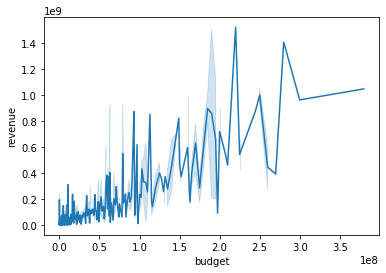

In [11]:
ax = sns.lineplot(x='budget', y='revenue', data=train)

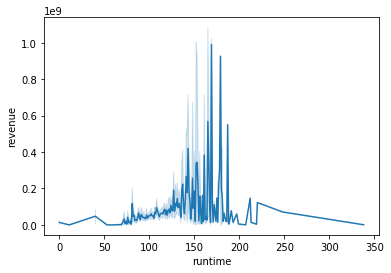

In [12]:
ax = sns.lineplot(x='runtime', y='revenue', data=train)

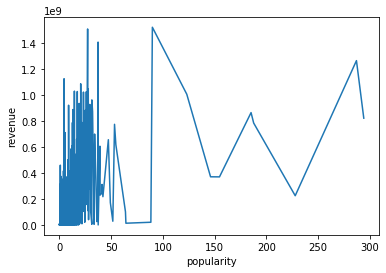

In [13]:
ax = sns.lineplot(x='popularity', y='revenue', data=train)

# Hmmmmm hvordan kan vi gjøre denne litt bedre

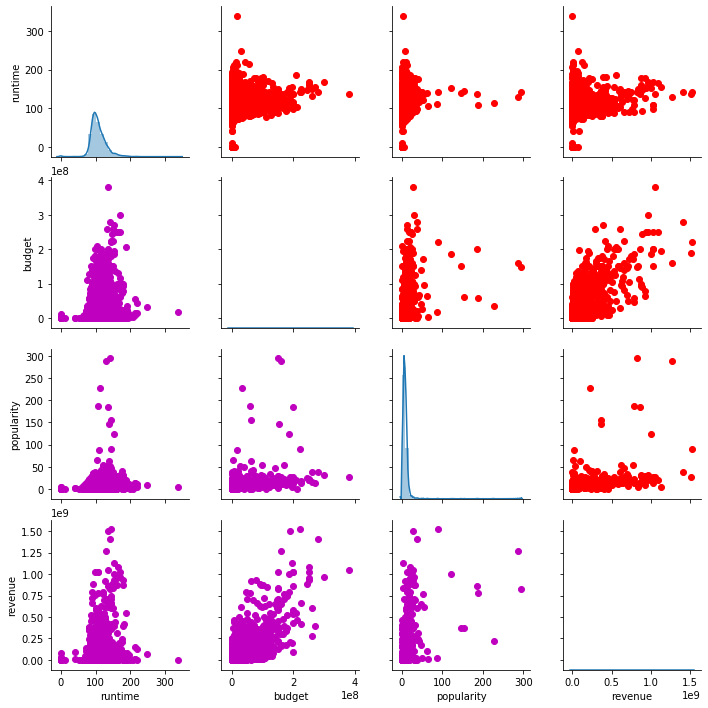

In [14]:
fig = sns.PairGrid(train[['runtime', 'budget', 'popularity', 'revenue']].dropna()) #dropna dropper nullverdier

fig.map_upper(plt.scatter, color = 'red')
fig.map_lower(plt.scatter, color = 'm')
fig.map_diag(sns.distplot, bins = 30)

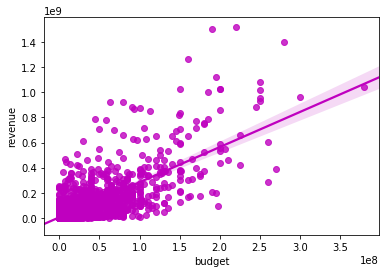

In [15]:
ax = sns.regplot(x="budget", y="revenue", data=train, color ="m", ) 
#1e9 = 10^9

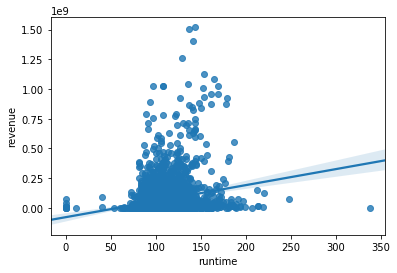

In [16]:
ax = sns.regplot(x="runtime", y="revenue", data=train)

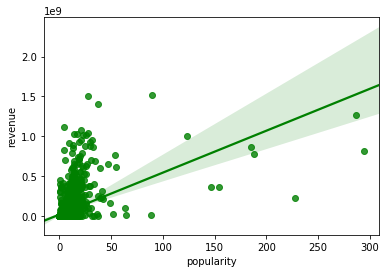

In [17]:
ax = sns.regplot(x="popularity", y="revenue", data=train, color ="g")

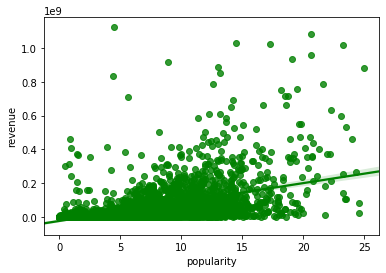

In [18]:
popularity_under_25 = train[train['popularity']<25]
ax = sns.regplot(x="popularity", y="revenue", data=popularity_under_25, color ="g")

zooming in on the popularity below 25 we see further that there seem to be a coalition between the two features

# We see that budget and popularity has a big impact on revenue earned. Runtime also has some impact, although not as much as the previous two 

# Data cleaning

As expected, there are many null values

In [19]:
train.isnull().sum().sum()

5601

Missing by feature:

In [20]:
pd.set_option("display.max_rows", None) # To print all rows below

In [21]:
train.isnull().sum().sort_values(ascending=False)

belongs_to_collection    2396
homepage                 2054
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
spoken_languages           20
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
poster_path                 1
original_language           0
budget                      0
imdb_id                     0
revenue                     0
original_title              0
popularity                  0
release_date                0
status                      0
title                       0
id                          0
dtype: int64

With closer inspection we see that there are few variables that have missing values

In [22]:
test.isnull().sum().sort_values(ascending=False)

belongs_to_collection    3521
homepage                 2978
tagline                   863
Keywords                  393
production_companies      258
production_countries      102
spoken_languages           42
crew                       22
genres                     16
overview                   14
cast                       13
runtime                     4
title                       3
status                      2
poster_path                 1
release_date                1
original_language           0
imdb_id                     0
original_title              0
popularity                  0
budget                      0
id                          0
dtype: int64

# Using the mean should be enough


Let's start by removing all none-nueric values, fixing them and then add other relevant data to the fianl preparred set.

In [24]:
#Select numeric values and fill na.
train_num = train.filter(['budget','popularity','runtime','revenue'],axis=1)
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
budget        3000 non-null int64
popularity    3000 non-null float64
runtime       2998 non-null float64
revenue       3000 non-null int64
dtypes: float64(2), int64(2)
memory usage: 93.9 KB


In [25]:
#Add boolean feature to say if its part of a collection
train_num["is_part_of_collection"] = ~train["belongs_to_collection"].isnull()

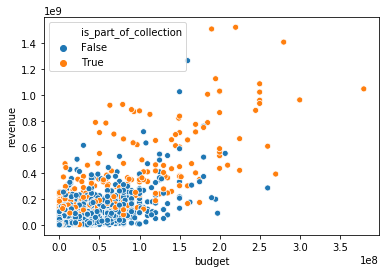

In [26]:
sns.scatterplot(data=train_num, x="budget", y="revenue", hue="is_part_of_collection")

<h3>This shows clearly that many high-revenue movies are part of a collection.

In [27]:
train_num.fillna(train_num.median(), inplace=True)

In [28]:
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
budget                   3000 non-null int64
popularity               3000 non-null float64
runtime                  3000 non-null float64
revenue                  3000 non-null int64
is_part_of_collection    3000 non-null bool
dtypes: bool(1), float64(2), int64(2)
memory usage: 96.8 KB


<h3>Lets make a method for looking into the release dates

In [29]:
import datetime as dt
import dateutil.relativedelta as relativedelta

#transforms year to epoch seconds. If release date is after current day it will be corrected 100 years back in time
def transform_year(date):
    if type(date) is str:
            now = dt.datetime.now().timestamp()
            date_in_seconds = dt.datetime.strptime(date, "%m/%d/%y").timestamp()
            if date_in_seconds > now:
                date_in_seconds -= 100*365.24*24*60*60
                return date_in_seconds
            else:
                return date_in_seconds

In [30]:
train_num["release_date"] = [transform_year(date) for date in train['release_date']]

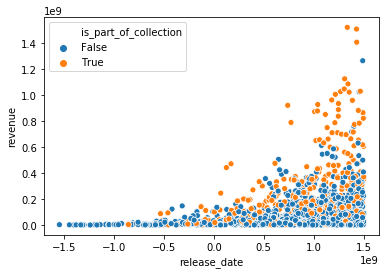

In [34]:
sns.scatterplot(data=train_num, x="release_date", y="revenue", hue="is_part_of_collection")

<h3>We see a clear connection between the release dates and the revenue

<h3>Now fill NANs

In [35]:
train_num.fillna(train_num.median(), inplace=True)

In [36]:
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
budget                   3000 non-null int64
popularity               3000 non-null float64
runtime                  3000 non-null float64
revenue                  3000 non-null int64
is_part_of_collection    3000 non-null bool
release_date             3000 non-null float64
dtypes: bool(1), float64(3), int64(2)
memory usage: 120.2 KB


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

language_categories = [train['original_language'].unique()]
train_num['original_language'] = train['original_language']
train_num.head()
col_trans = ColumnTransformer([('ori_lan', OneHotEncoder(categories=language_categories), ['original_language'])], remainder='passthrough')
train_num_prep = col_trans.fit_transform(train_num)

In [39]:
train_num_prep.shape

(3000, 42)

In [40]:
#def get_production_company(data):
#    if type(data) is str:
#        prod_comp = (eval(data))
#        prod_comp_names_list = []
#        for i in range(len(prod_comp)):
#            prod_comp_names_list.append(prod_comp[i]['name'])
#        return prod_comp_names_list
#    
#train_num['prod_comp'] = train['production_companies']
#for i in range(len(train_num['prod_comp'])):
#    train_num['prod_comp'][i] = get_production_company(train_num['prod_comp'][i])
#    
#train_num.head()

<h3>Finally we make our pipeline method for preparring the dataset

In [47]:
#transformation method. 
def full_pipeline(dataset, trainset):
    data_num = dataset.filter(['budget','popularity','runtime'], axis=1)
    data_num["is_part_of_collection"] = ~dataset["belongs_to_collection"].isnull()
    data_num['release_date'] = [transform_year(date) for date in dataset['release_date']]
    data_num.fillna(data_num.median(), inplace=True)
    
    data_num['original_language'] = dataset['original_language']
    language_categories = [trainset['original_language'].unique()]
    col_trans = ColumnTransformer([
        ('ori_lan', OneHotEncoder(categories=language_categories, sparse=False, dtype='int64', handle_unknown='ignore'), ['original_language'])
    ], remainder='passthrough')
    
    return col_trans.fit_transform(data_num)

<h3>Let's remove the labels and get going

In [48]:
labels = train['revenue']
preparred_trainingset = full_pipeline(train,train)

In [49]:
labels.head()

0    12314651
1    95149435
2    13092000
3    16000000
4     3923970
Name: revenue, dtype: int64

In [50]:
for i in preparred_trainingset[1]:
    print(i, end=' ')

1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40000000 8.248895 113.0 True 1091743200.0 

<h3>Model training time.
   

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

forrest_reg = RandomForestRegressor(n_estimators=500, bootstrap=True, n_jobs=-1)
forrest_reg.fit(preparred_trainingset, labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [59]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [60]:
scores = cross_val_score(forrest_reg, 
                         preparred_trainingset, 
                         labels, 
                         scoring="neg_mean_squared_log_error", 
                         cv=10)
forrest_rmse_scores = np.sqrt(-scores)
display_scores(forrest_rmse_scores)

Scores: [2.5248824  2.68597395 2.50473844 2.77981703 2.54102986 2.44024853
 2.69793002 2.58529977 2.45272131 2.23604429]
Mean: 2.5448685603824654
Standard deviation: 0.14731174933741567


In [63]:
preparred_trainingset.shape

(3000, 41)

In [259]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

In [292]:
test_prep = full_pipeline(test,train)

In [293]:
forrest_reg.predict(test_prep)

array([31117429.06,  5618694.84, 14891466.89, ..., 60298045.83,
       71147198.64, 12520119.28])